In [1]:
%matplotlib widget

import os
import sys
from IPython import embed
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from matplotlib.table import Table
import pickle
import numpy as np
import yaml

## methods for evaluating training results
sys.path.append("../core")
from model import CAI_Model

## methods for evaluating resims
sys.path.append(os.path.abspath("/develop/code/cai_2023/evaluation"))
import eval_methods as em

sys.path.append(os.path.abspath("/develop/code/cai_2023/resim"))
import launch_resim as launch

path_results = "/develop/results"

Global seed set to 1337


define `min_list` and `max_list` according to [`total`, `near field`, `far field`, `phase`, `curvature`] to set ymin and ymax in the loss plots

In [2]:
min_list = [None, None, None, None, None]
max_list = [None, None, None, None, None]

plt.close("all")
plt.style.use("ggplot")

from matplotlib.font_manager import FontProperties
fontsize = 8
font = FontProperties()

def plot_loss(loss, title, min, max, save_fig):
    
    plt.style.use("ggplot")
    
    fig, ax = plt.subplots(2, int((len(loss.keys()) - 1)/2), figsize = (12, 4.5))
        
    lterms = ['Total Loss', 'Near Field Loss', 'Far Field Loss', 'Phase Loss', 'Curvature Loss']
    
    for i, name in enumerate(loss.keys()):
        
        if(name == "epoch"):
            continue

        if(name.startswith('val')):
            #fig.suptitle(f"\nLoss Analysis {title}: " + "Valid Dataset", fontsize=fontsize, fontproperties=font)
            
            x_vals = loss["epoch"]
            x_vals = x_vals[x_vals.index % 2 == 0]
            y_vals = loss[name]
            y_vals = y_vals[y_vals.index % 2 == 0]
            
            ax[1][i].plot(x_vals, y_vals, color = "blue", label=title)
            ax[1][i].set_ylabel("Loss", fontsize = fontsize-1)
            ax[1][i].set_xlabel("Epoch", fontsize = fontsize-1)
            ax[1][i].set_title(name,fontsize=fontsize+1)
            ax[1][i].tick_params(axis="x", labelsize=6)
            ax[1][i].tick_params(axis="y", labelsize=6)
            #ax[1][i].legend(loc='upper right', fontsize=fontsize)
            ax[1][i].set_ylim([min[i],max[i]])
            
        else:
            #fig.suptitle(f"\nLoss Analysis {title}: " + "Train Dataset", fontsize=fontsize, fontproperties=font)

            x_vals = loss["epoch"]
            x_vals = x_vals[x_vals.index % 2 != 0]
            y_vals = loss[name]
            y_vals = y_vals[y_vals.index % 2 != 0]
            
            ax[0][i-6].plot(x_vals, y_vals, color = "blue", label=title)
            ax[0][i-6].set_ylabel("Loss", fontsize = fontsize-1)
            ax[0][i-6].set_xlabel("Epoch", fontsize = fontsize-1)
            ax[0][i-6].set_title(name,fontsize=fontsize+1)
            ax[0][i-6].tick_params(axis="x", labelsize=6)
            ax[0][i-6].tick_params(axis="y", labelsize=6)
            ax[0][i-6].set_ylim([0,100])
            #ax[0][i-6].legend(loc='upper right', fontsize=fontsize)
            ax[0][i-6].set_ylim([min[i-6],max[i-6]])
            
    fig.suptitle(title)
    fig.tight_layout()

    if save_fig == True:
        temp = title.replace(l_string, "").replace("\n", "").replace(": ", "").replace(" ", "_").replace("=", "").replace("(", "").replace(")", "").replace(".", "-")
        new_title = "a_b_d_g_" + temp
        
        if(fig.savefig(f'loss_plots/{new_title}.pdf')):
            print("fig saved")

define `folder_name` to choose a single model for which to plot loss

In [28]:
########################################
#### plot loss for a single model #####

folder_name = "model_0031"
folder_path = os.path.join(path_results, folder_name)
single_loss = em.gather_loss(folder_path)

l_string = r'($\alpha$' + " " + r'$\beta$' + " " + r'$\delta$' + " " + r'$\gamma$)'
title = l_string + f": ({single_loss['alpha']} {single_loss['beta']} {single_loss['delta']} {single_loss['gamma']}) " + "\n" + single_loss['title'].replace(path_results,"").replace("/","") + " lr=" + str(single_loss['lr'])

#plot_loss(single_loss['loss'], title, max_list, min_list, False)

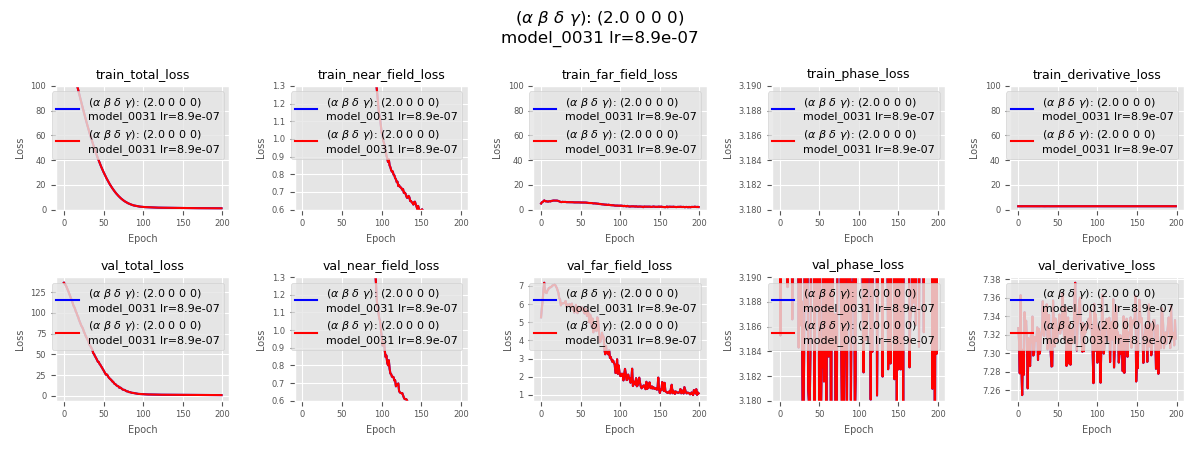

In [35]:


folder_name = "model_0041"
folder_path = os.path.join(path_results, folder_name)
single_loss2 = em.gather_loss(folder_path)

l_string = r'($\alpha$' + " " + r'$\beta$' + " " + r'$\delta$' + " " + r'$\gamma$)'
title2 = l_string + f": ({single_loss['alpha']} {single_loss['beta']} {single_loss['delta']} {single_loss['gamma']}) " + "\n" + single_loss['title'].replace(path_results,"").replace("/","") + " lr=" + str(single_loss['lr'])

#plot_loss(single_loss['loss'], title, max_list, min_list, False)

#[total, near field, far field, phase, curvature
min_list = [None, 0.6, None, 3.18, None]
max_list = [None, 1.3, None, 3.19, None]
plot_two(single_loss['loss'], title, single_loss2['loss'], title2, min_list, max_list, False)

In [4]:
 ###############################################################
#### Plot loss for all models with the specified backbone #####
backbone = "resnet18" 
#backbone = "resnet34"
#backbone = "resnet50"

####################################
#### Plot loss by learning rate ####

all_loss = em.gather_all_loss(path_results, backbone)

lr_list = []
for result in all_loss:
    lr = result['lr']
    if lr not in lr_list:
        lr_list.append(lr)
lr_list.sort()
print(f"we have {len(lr_list)} learning rates for backbone {backbone}.")

num folders found: 303
number with loss: 303
we have 10 learning rates for backbone resnet18.


In [5]:
all_alpha, all_beta, all_delta = [], [], []

def grab_loss(result):

    loss = result['loss']
    loss.keys()
    title = l_string +  f": ({result['alpha']} {result['beta']} {result['delta']} {result['gamma']}) " + "\n" + result['title'].replace(path_results,"").replace("/","") + " lr=" + str(result['lr'])
    #plot_loss(loss, title, max_list, min_list)
    
    return loss, title

for result in all_loss:
    
    if result['alpha'] != 0:
        all_alpha.append(result)
    if result['beta'] != 0:
        all_beta.append(result)
    if result['delta'] != 0:
        all_delta.append(result)

(0.9, 2.0)

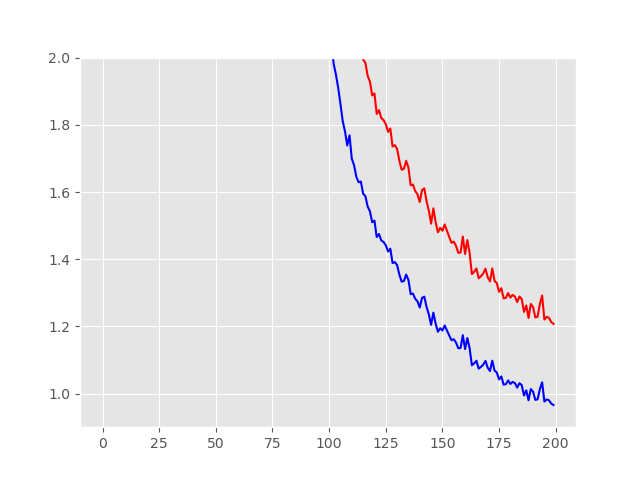

In [68]:
temp = [j for i,j in enumerate(all_alpha[31]['loss']['train_total_loss']) if i % 2 != 0]
title = all_alpha[31]['title']
temp2 = [j for i,j in enumerate(all_alpha[41]['loss']['train_total_loss']) if i % 2 != 0]
title2 = all_alpha[41]['title']
np.asarray(temp)==np.asarray(temp2)
fig, ax = plt.subplots(1,1)
ax.plot(temp, "blue")
ax.plot(temp2, "red")
ax.set_ylim([0.9, 2])


## first all the alphas

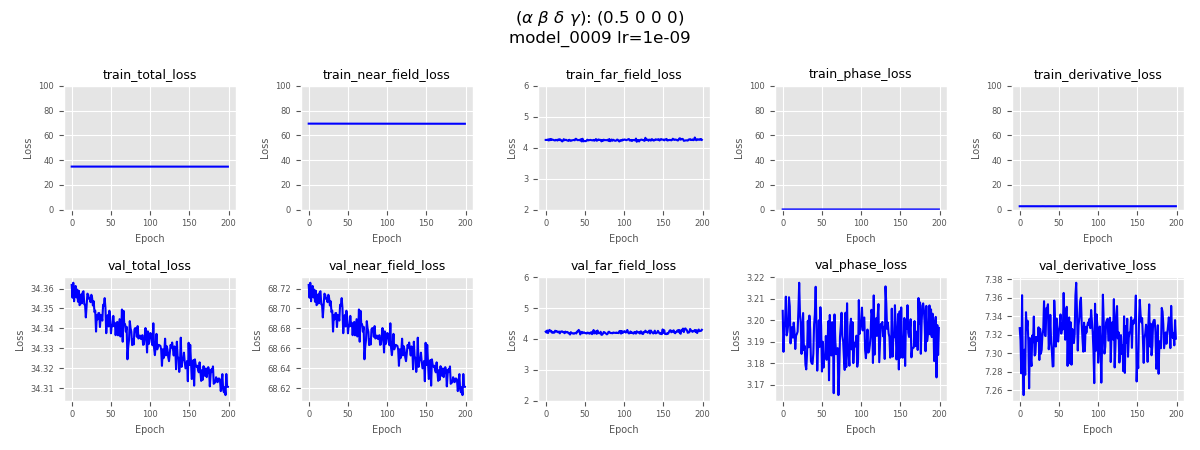

In [92]:
for result in all_alpha:
    if result['lr'] == lr_list[0]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

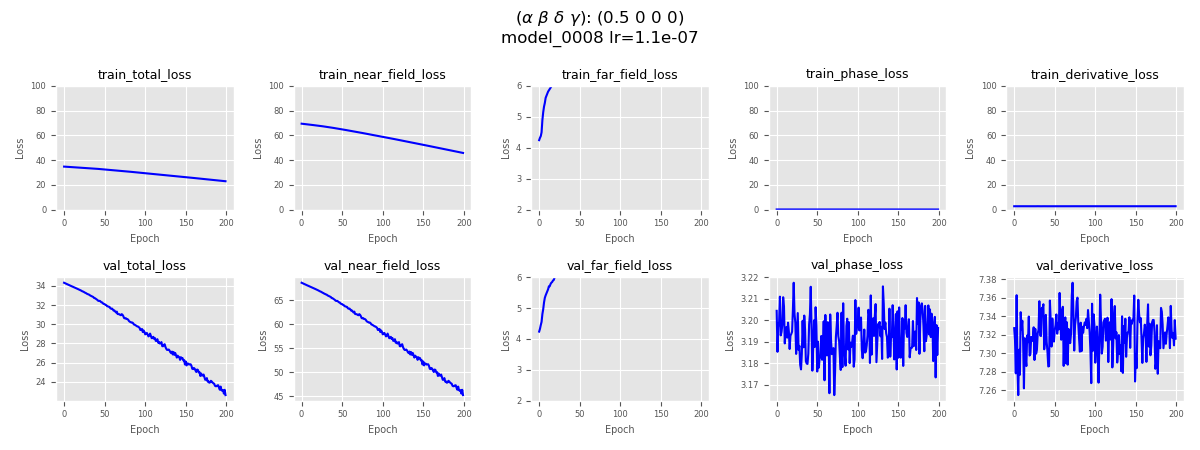

In [93]:
plt.close("all")

for result in all_alpha:
    if result['lr'] == lr_list[1]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

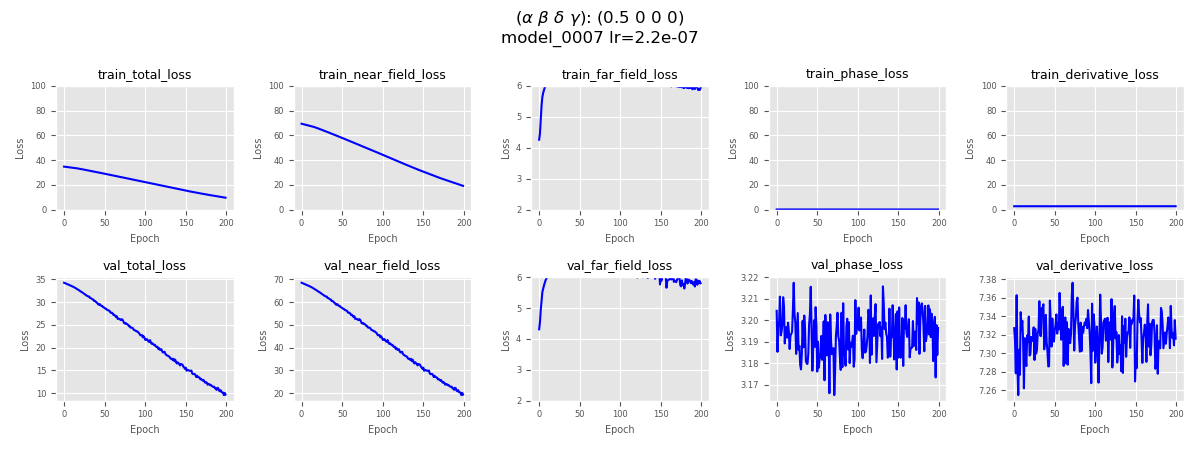

In [94]:
plt.close("all")

for result in all_alpha:
    if result['lr'] == lr_list[2]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

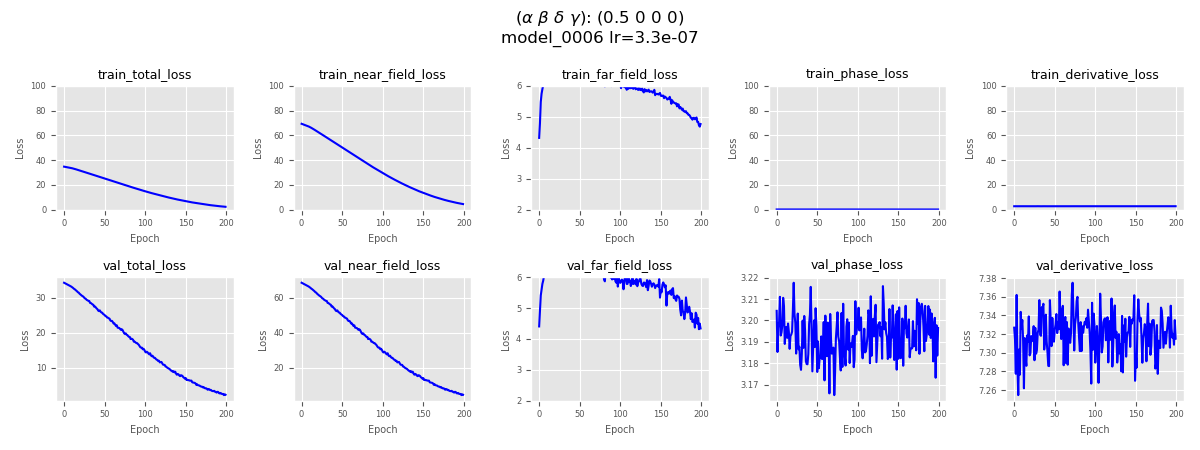

In [95]:
plt.close("all")

for result in all_alpha:
    if result['lr'] == lr_list[3]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

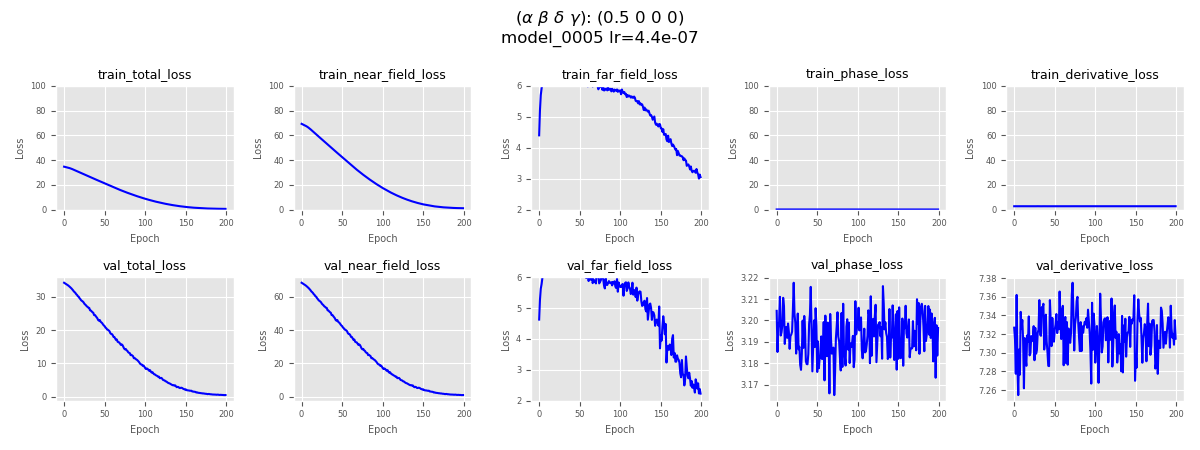

In [96]:
plt.close("all")

for result in all_alpha:
    if result['lr'] == lr_list[4]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

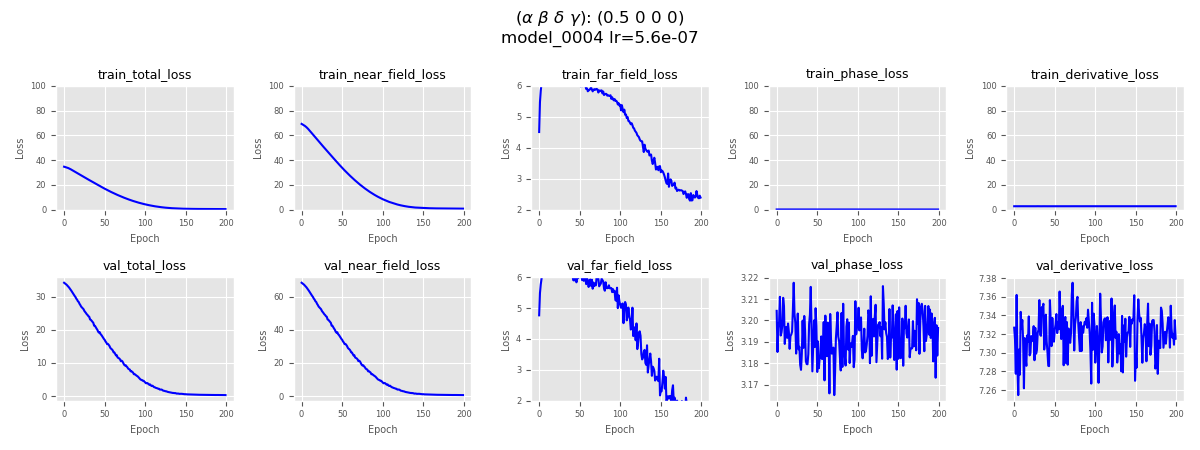

In [98]:
plt.close("all")

for result in all_alpha:
    if result['lr'] == lr_list[5]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

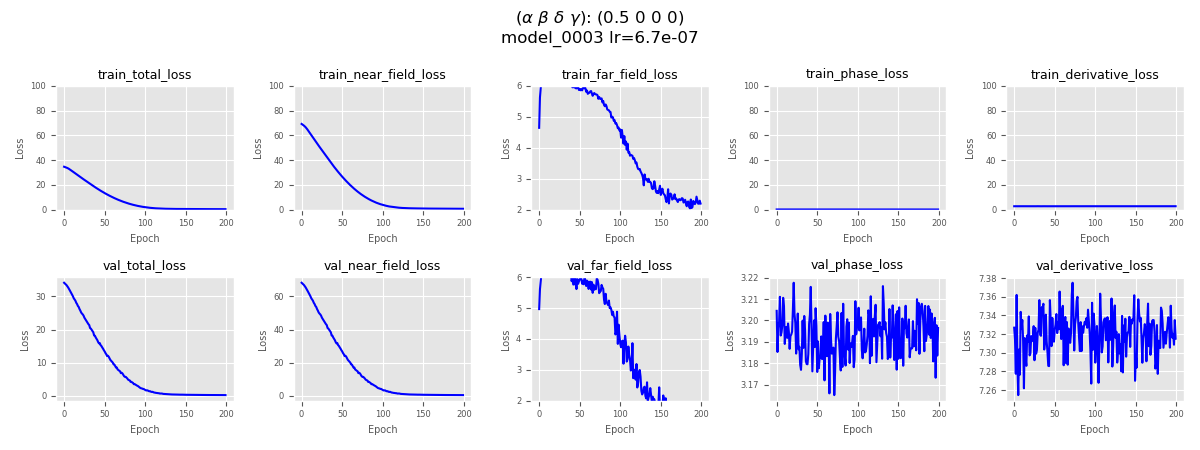

In [100]:
plt.close("all")

for result in all_alpha:
    if result['lr'] == lr_list[6]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

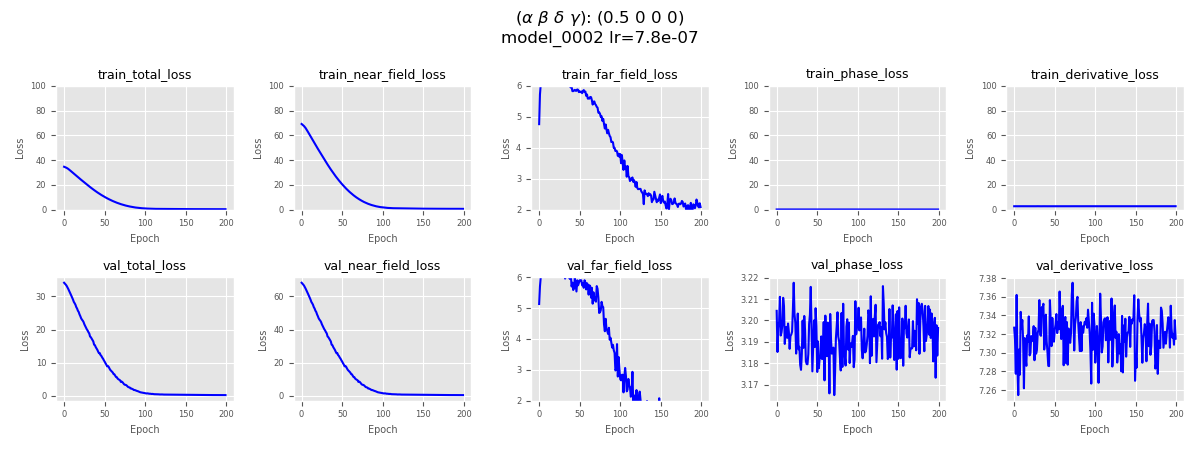

In [101]:
plt.close("all")

for result in all_alpha:
    if result['lr'] == lr_list[7]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

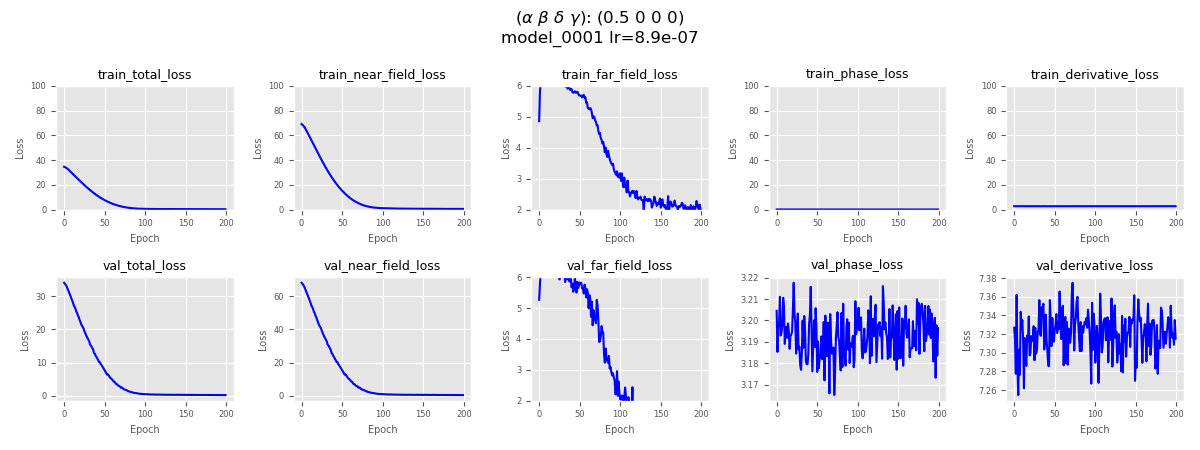

In [102]:
plt.close("all")

for result in all_alpha:
    if result['lr'] == lr_list[8]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

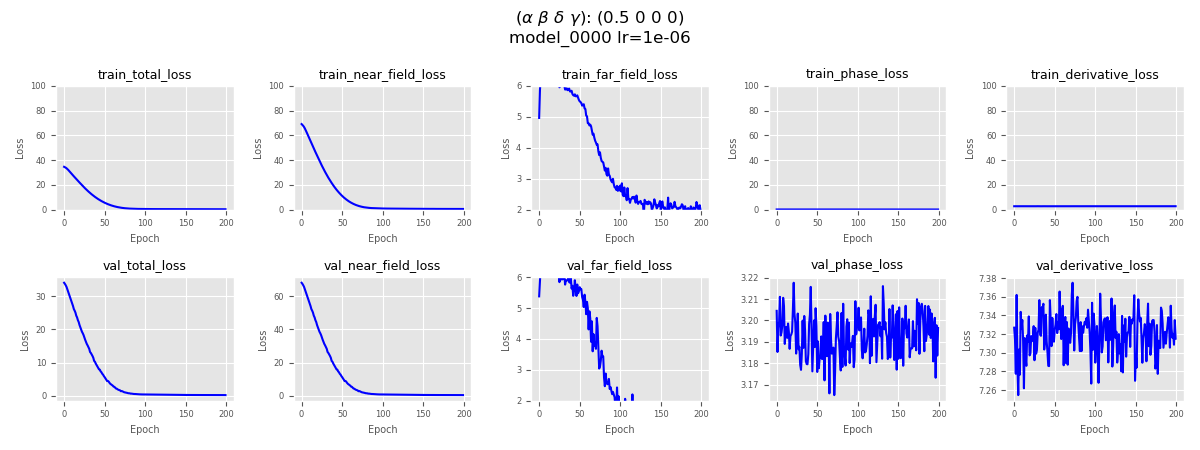

In [103]:
plt.close("all")

for result in all_alpha:
    if result['lr'] == lr_list[9]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

## now all the betas

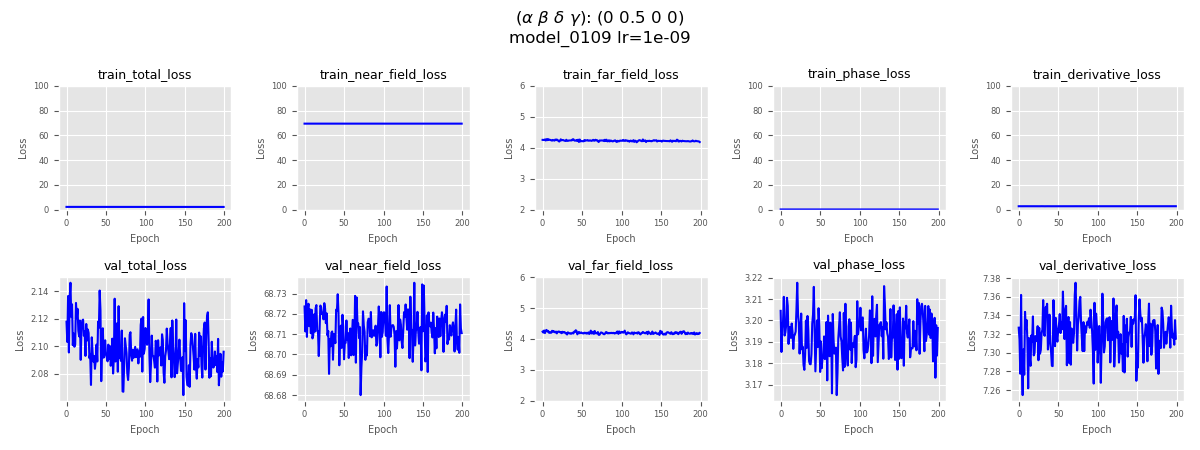

In [88]:
plt.close("all")
min_list = [None, None, 2, None, None]
max_list = [None, None, 6, None, None]
for result in all_beta:
    if result['lr'] == lr_list[0]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

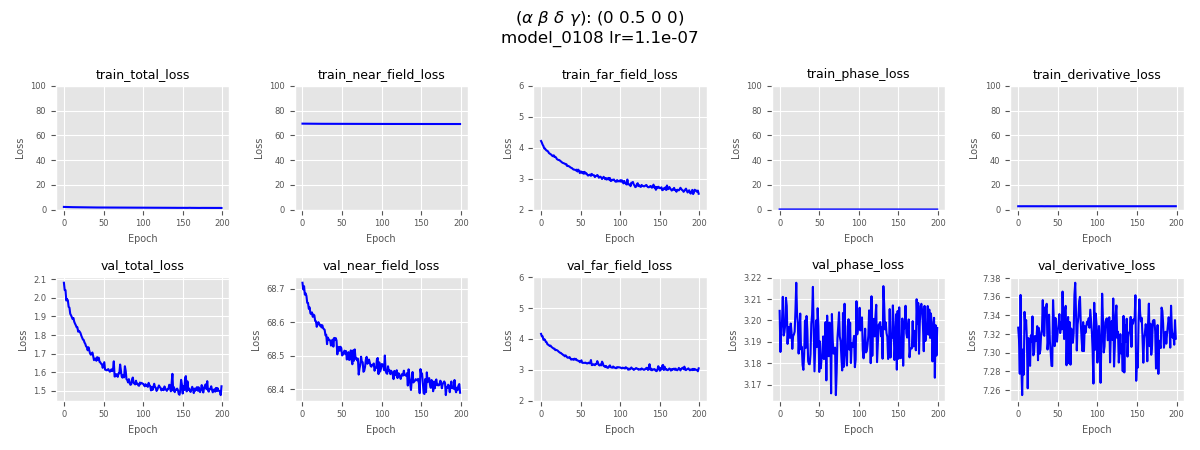

In [89]:
plt.close("all")

for result in all_beta:
    if result['lr'] == lr_list[1]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

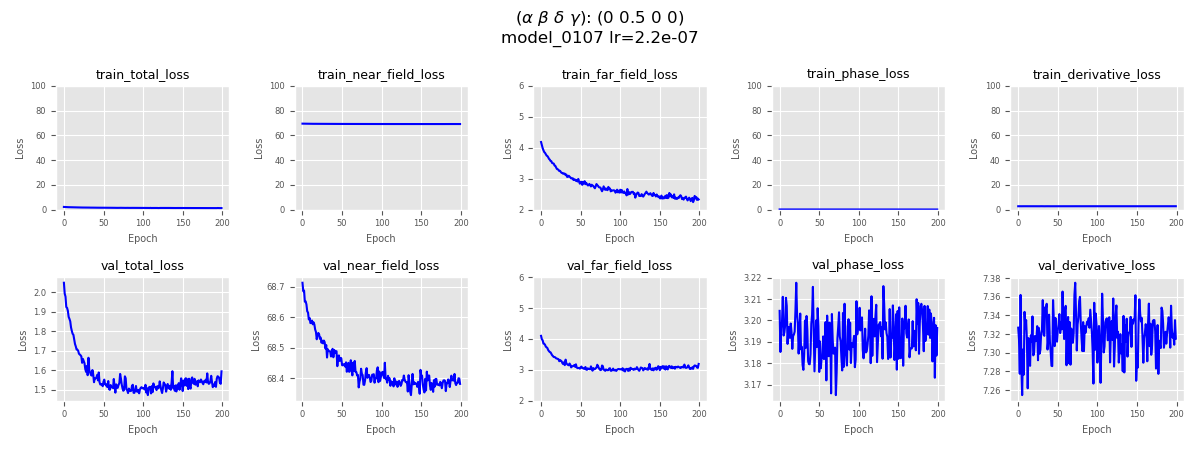

In [90]:
plt.close("all")

for result in all_beta:
    if result['lr'] == lr_list[2]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

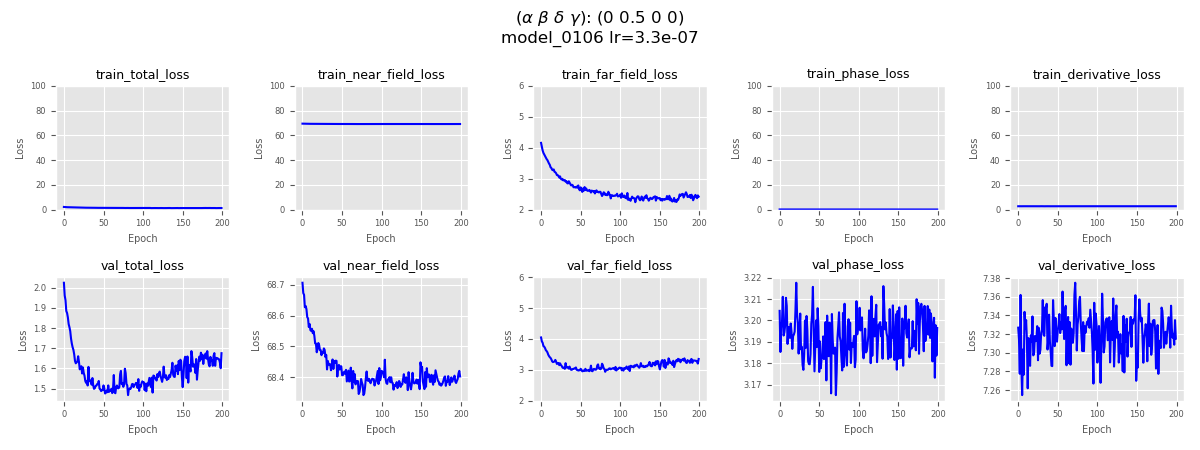

In [91]:
plt.close("all")

for result in all_beta:
    if result['lr'] == lr_list[3]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

In [104]:
# plt.close("all")

# for result in all_beta:
#     if result['lr'] == lr_list[4]:
#         loss, title = grab_loss(result)
#         plot_loss(loss, title, min_list, max_list, True)

In [105]:
# plt.close("all")

# for result in all_beta:
#     if result['lr'] == lr_list[5]:
#         loss, title = grab_loss(result)
#         plot_loss(loss, title, min_list, max_list, True)

In [106]:
# plt.close("all")

# for result in all_beta:
#     if result['lr'] == lr_list[6]:
#         loss, title = grab_loss(result)
#         plot_loss(loss, title, min_list, max_list, True)

In [107]:
# plt.close("all")

# for result in all_beta:
#     if result['lr'] == lr_list[7]:
#         loss, title = grab_loss(result)
#         plot_loss(loss, title, min_list, max_list, True)

In [108]:
# plt.close("all")

# for result in all_beta:
#     if result['lr'] == lr_list[8]:
#         loss, title = grab_loss(result)
#         plot_loss(loss, title, min_list, max_list, True)

In [109]:
# plt.close("all")

# for result in all_beta:
#     if result['lr'] == lr_list[9]:
#         loss, title = grab_loss(result)
#         plot_loss(loss, title, min_list, max_list, True)

## now all the deltas

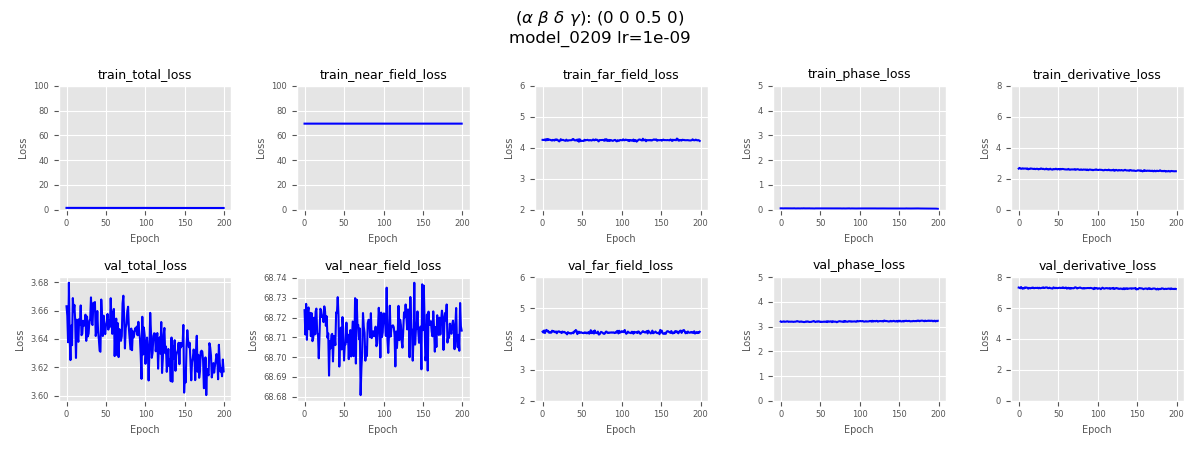

In [122]:
plt.close("all")
min_list = [None, None, 2, 0, 0]
max_list = [None, None, 6, 5, 8]

for result in all_delta:
    if result['lr'] == lr_list[0]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

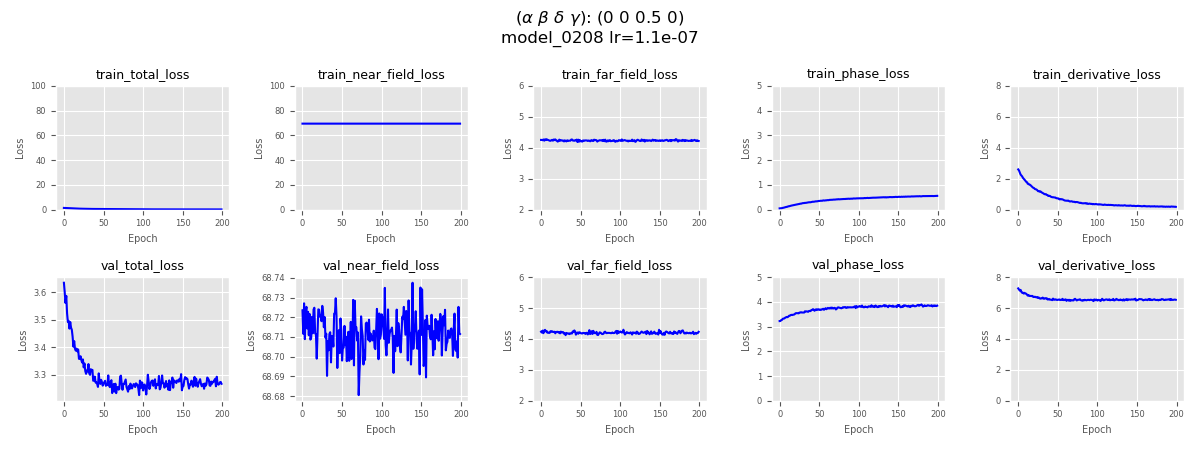

In [123]:
plt.close("all")

for result in all_delta:
    if result['lr'] == lr_list[1]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

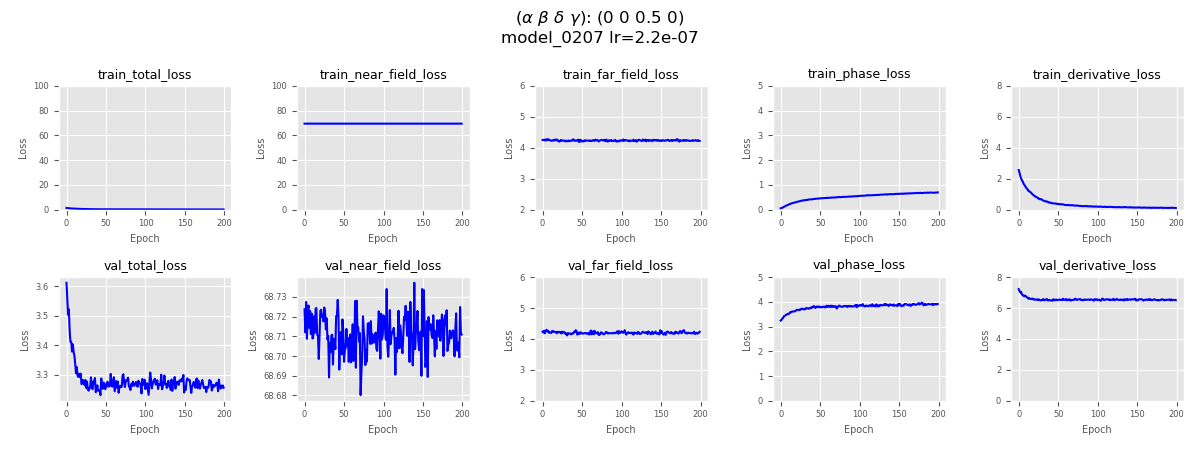

In [124]:
plt.close("all")

for result in all_delta:
    if result['lr'] == lr_list[2]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

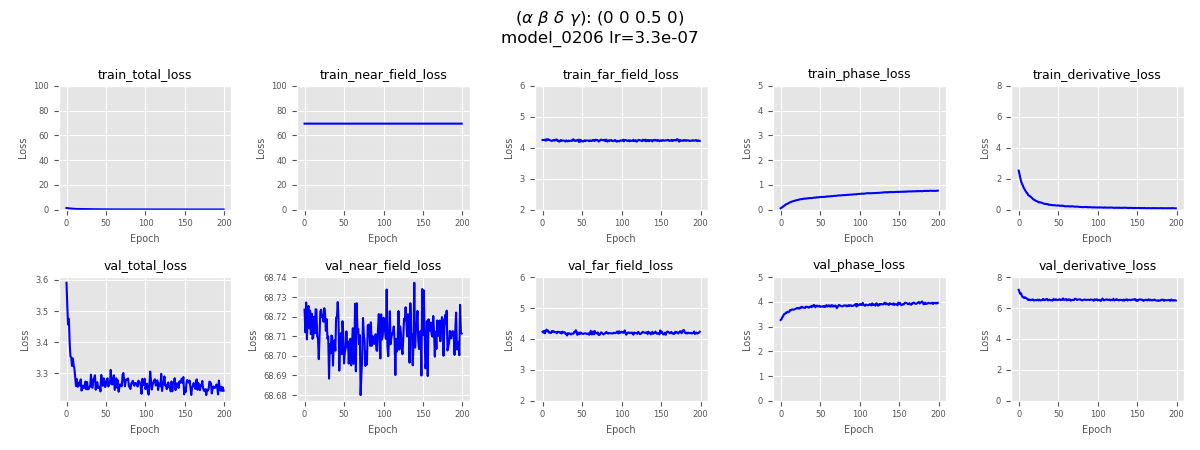

In [125]:
plt.close("all")

for result in all_delta:
    if result['lr'] == lr_list[3]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

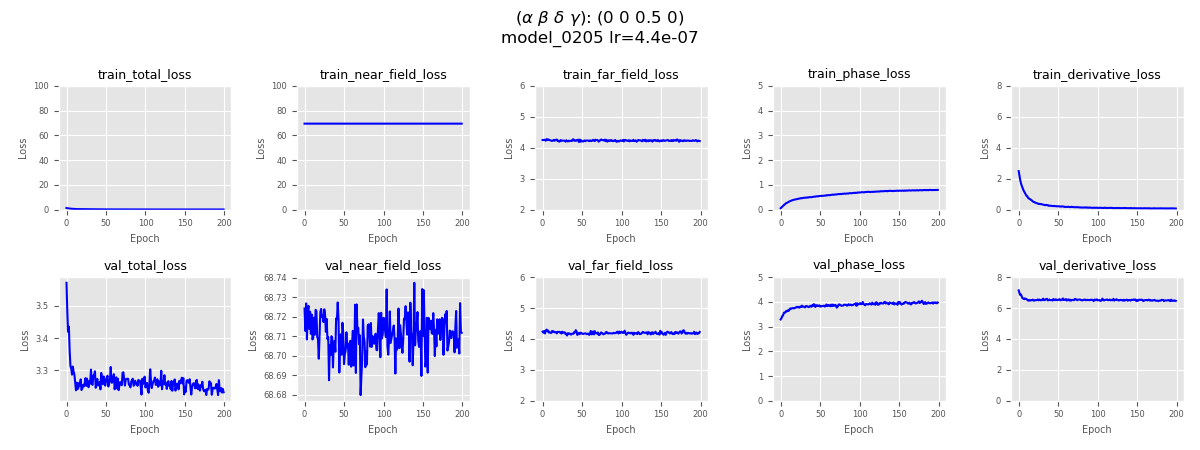

In [126]:
plt.close("all")

for result in all_delta:
    if result['lr'] == lr_list[4]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

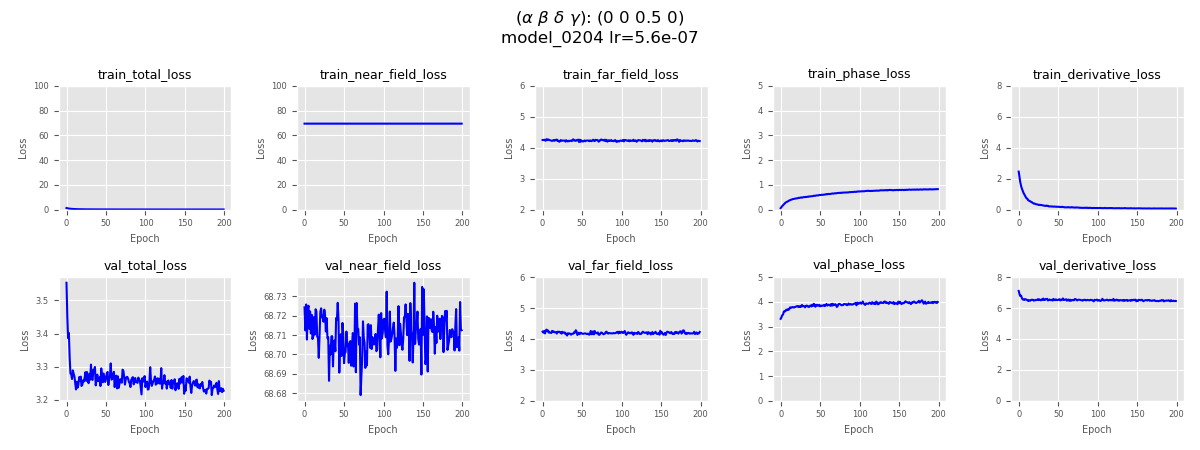

In [127]:
plt.close("all")

for result in all_delta:
    if result['lr'] == lr_list[5]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

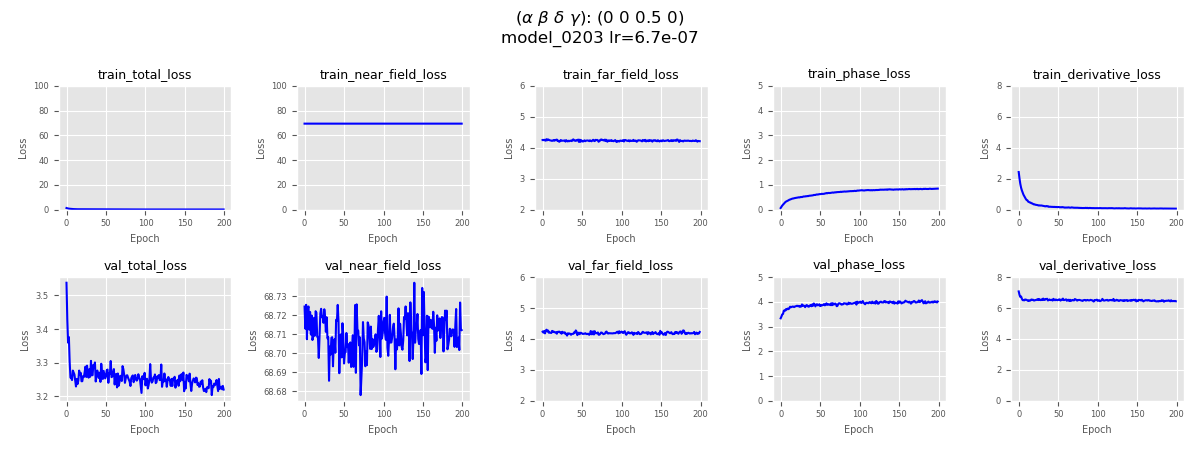

In [128]:
plt.close("all")

for result in all_delta:
    if result['lr'] == lr_list[6]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

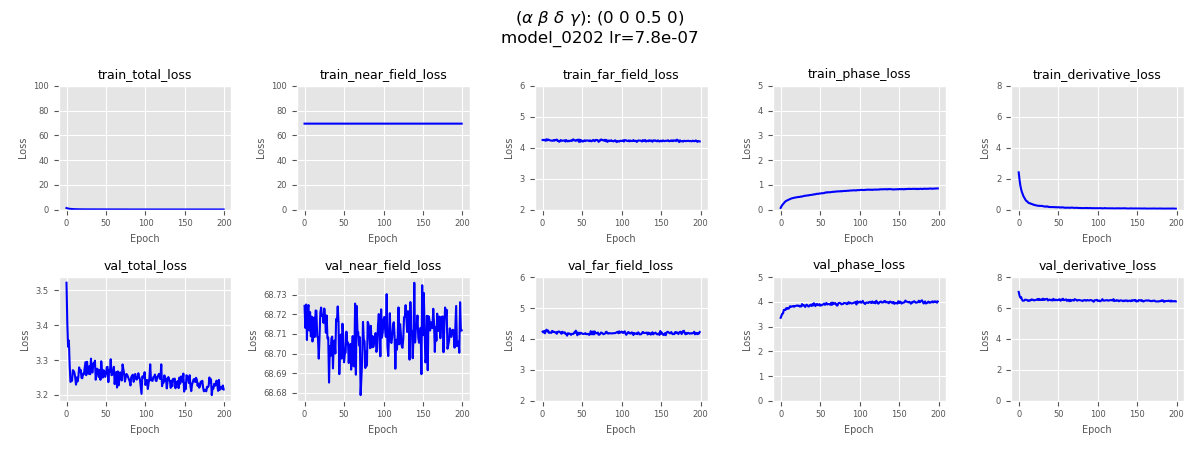

In [129]:
plt.close("all")

for result in all_delta:
    if result['lr'] == lr_list[7]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

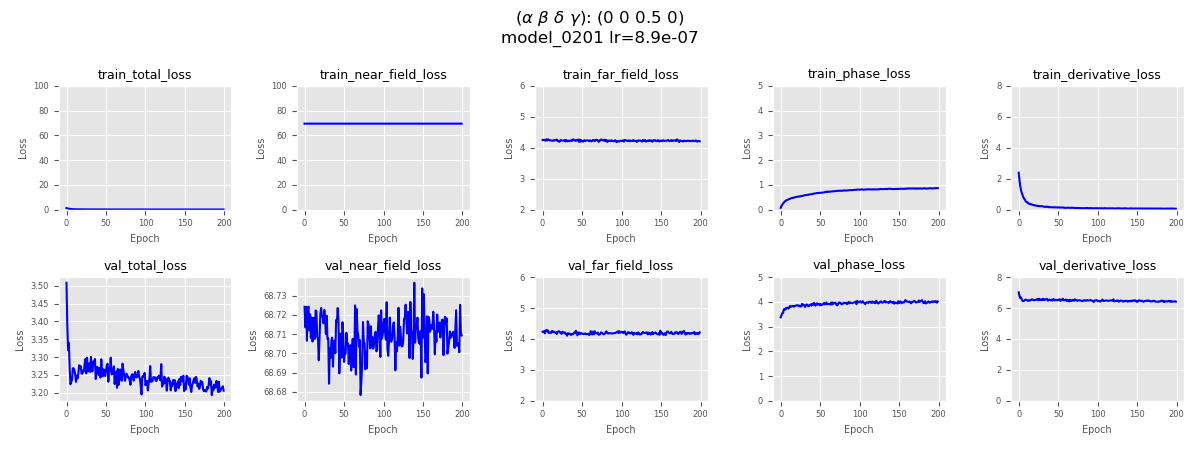

In [130]:
plt.close("all")

for result in all_delta:
    if result['lr'] == lr_list[8]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

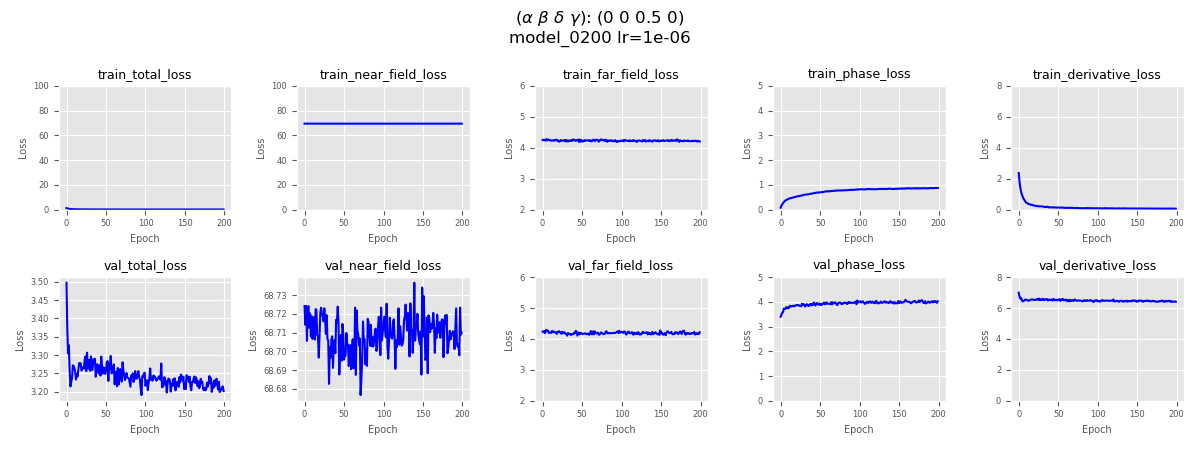

In [131]:
plt.close("all")

for result in all_delta:
    if result['lr'] == lr_list[9]:
        loss, title = grab_loss(result)
        plot_loss(loss, title, min_list, max_list, True)
        break

In [ ]:
def plot_scatter(train_results, valid_results, title):
    fig, ax = plt.subplots(1, 2, figsize = (9,3))
    fig.suptitle(title)

    ax[0].scatter(train_results['truth_phase'], train_results['pred_phase'])
    ax[0].set_title("Train Dataset")
    ax[0].set_xlabel("Truth Phases")
    ax[0].set_ylabel("Pred Phases")

    ax[1].scatter(valid_results['truth_phase'], valid_results['pred_phase'])
    ax[1].set_title("Valid Dataset")
    ax[1].set_xlabel("Truth Phases")
    ax[1].set_ylabel("Pred Phases")

    fig.tight_layout()

#### compare gammas for encoder training models

In [ ]:
model_encoderOnly_list = []
batch_size = 1
print(path_results)

def load_models(string):
    
    num_folders = 0

    for folder in os.listdir(path_results):
        
        if string in folder:

            ckpt_path = f"/develop/results/model_checkpoints/{folder}"
            params_path = f"/develop/results/results/{folder}/params.yaml"

            try:
                with open(params_path, 'r') as file:
                    yaml_content = yaml.safe_load(file)
                    #print(f"found yaml file for {folder}")
                    key_dict = {}
                    key_dict['gamma'] = yaml_content['mcl_params']['gamma']
                    key_dict['backbone'] = yaml_content['backbone']
                    key_dict['learning_rate'] = yaml_content['learning_rate']
                
                    model = em.load_model(ckpt_path, params_path, batch_size)
                    data_loader_train, data_loader_valid = em.load_data(batch_size, params_path)
                    train_results = em.evaluate(model, data_loader_train)
                    valid_results = em.evaluate(model, data_loader_valid)
                    
                    key_dict['valid_truth_phase'] = valid_results['truth_phase']
                    key_dict['valid_pred_phase'] = valid_results['pred_phase']
                    key_dict['train_truth_phase'] = train_results['truth_phase']
                    key_dict['train_pred_phase'] = train_results['pred_phase']
                    key_dict['title'] = folder
                    
                    model_encoderOnly_list.append(key_dict)
            except FileNotFoundError:
                print(f"no yaml file for {folder}")
                

            num_folders += 1
            print(f"searched folder {num_folders}, {folder}")
            #plot_scatter(train_results, valid_results,folder)
            pass
    print(f"loaded in {num_folders} folders.")

load_models("model_encoderOnly_lrSweep_")


In [ ]:
# path = "/develop/results/results/results_05_23_model_encoderTraining"
# filename = 'sanity_check.pkl'

# pickle.dump(model_encoderOnly_list,open(os.path.join(path,filename),"wb"))

define `ckpt_path`, `params_path` and `batch_size` to load in the model you want

In [133]:
folder_name = "model_baselineEncoder"
ckpt_path = f"/develop/model_checkpoints/{folder_name}"
destination_path = "/cgi/data/erdc_xai/cai_2023/resims/radii_predictions"
params_path = os.path.join(path_results, f"{folder_name}/params.yaml")
batch_size = 1

print(ckpt_path)
print(params_path)

/develop/model_checkpoints/model_baselineEncoder
/develop/results/model_baselineEncoder/params.yaml


In [136]:
torch.multiprocessing.set_sharing_strategy('file_system')

model = em.load_model(ckpt_path, params_path, batch_size)
data_loader_train, data_loader_valid = em.load_data(batch_size, params_path)

train_results = em.evaluate(model, data_loader_train)
valid_results = em.evaluate(model, data_loader_valid)
results = {}
results['train'] = train_results[:5]
results['valid'] = valid_results[:5]
pickle.dump(results, open(os.path.join(destination_path, f"{folder_name}.pkl"), "wb"))

NameError: name 'torch' is not defined

In [ ]:
 def plot_violin(train_results, valid_results):
    
    fig, ax = plt.subplots(1, 2, figsize = (9,3))
    
    diff_train = train_results['pred_phase'] - train_results['truth_phase']
    diff_valid = valid_results['pred_phase'] = valid_results['pred_phase']
    
    ax[0].violinplot(diff_train)
    ax[0].boxplot(diff_train)
    ax[0].set_title("Train Dataset")
    ax[0].set_ylim([-6,6])
    ax[0].set_ylabel("Difference")
    ax[0].set_xlabel("Phase (Feature)")
    
    ax[1].violinplot(diff_valid)
    ax[1].boxplot(diff_valid)
    ax[1].set_title("Valid Dataset")
    ax[1].set_ylim([-6,6])
    ax[1].set_ylabel("Difference")
    ax[1].set_xlabel("Phase (Feature)")

    fig.tight_layout()

In [ ]:
plt.close("all")
plot_violin(train_results, valid_results)

In [ ]:
 def plot_scatter(train_results, valid_results):
    fig, ax = plt.subplots(1, 2, figsize = (9,3))

    ax[0].scatter(train_results['truth_phase'], train_results['pred_phase'])
    ax[0].set_title("Train Dataset")
    ax[0].set_xlabel("Truth Phases")
    ax[0].set_ylabel("Pred Phases")

    ax[1].scatter(valid_results['truth_phase'], valid_results['pred_phase'])
    ax[1].set_title("Valid Dataset")
    ax[1].set_xlabel("Truth Phases")
    ax[1].set_ylabel("Pred Phases")

    fig.tight_layout()

In [ ]:
 plt.close("all")
#plt.scatter(truth_phase_array, pred_phase_array);
plot_scatter(train_results, valid_results)

In [ ]:
def plot_regs():
    

### launch resims

#### num_resims = 5

### start a container ####

sys.path.append(os.path.abspath("/develop/code/cai_2023/resim"))
!sudo docker run -d --gpus all --ipc host -it -v /home/agkgd4/Documents/code:/develop/code -v /home/agkgd4/Documents/data:/develop/data -v /home/agkgd4/Documents/results:/develop/results cai


#launch(train_results)
#launch(valid_results)